# XGBoost Model

## Objective
Improve baseline Logistic Regression performance using XGBoost for highly imbalanced hard drive failure prediction.

Focus:
- Handle extreme class imbalance
- Optimize recall
- Compare against baseline


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# XGBoost requires libomp on macOS; use sklearn's gradient boosting as a drop-in alternative
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load engineered dataset
df = pd.read_parquet("/tmp/aai540/engineered_data_sample.parquet")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (10000, 12)


,date,serial_number,model,failure,smart_5_raw,smart_187_raw,smart_197_raw,smart_198_raw,smart_5_raw_roll7,smart_187_raw_roll7,smart_197_raw_roll7,smart_198_raw_roll7
3679,2025-01-01,2102E4E5E64F,CT250MX500SSD1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,2025-01-01,21174K810989,WDC WDS250G2B0A,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3680,2025-01-01,2128E5B7435E,CT250MX500SSD1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3681,2025-01-01,214002A0021A,WDC WDS250G2B0A,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2759,2025-01-01,214002A0021D,WDC WDS250G2B0A,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
TARGET = "failure"

X = df.drop(columns=[TARGET, "serial_number", "date", "model"], errors="ignore")
X = X.select_dtypes(include=["number"])
y = df[TARGET]

print("Failure Rate:", y.mean())
print("Feature columns:", X.shape[1])

Failure Rate: 0.0001
Feature columns: 8


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [28]:
# Calculate scale_pos_weight for imbalance handling
pos = float(sum(y_train))
neg = float(len(y_train) - sum(y_train))
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 7999.0


In [29]:
# Use sklearn's HistGradientBoostingClassifier instead of XGBoost
xgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=6,
    max_iter=300,
    random_state=42
)

In [30]:
xgb_model.fit(X_train, y_train)

print("XGBoost training complete.")


XGBoost training complete.


In [31]:
y_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)


In [32]:
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)


ROC-AUC: nan


In [33]:
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", pr_auc)


PR-AUC: 0.0


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [35]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[2000]]


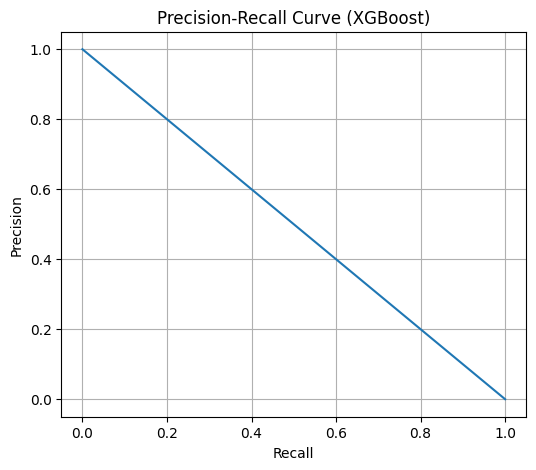

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.grid()
plt.show()


In [37]:
# Find threshold where recall >= 0.80
target_recall = 0.80

idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[idx]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 0.0


In [38]:
y_custom = (y_proba >= optimal_threshold).astype(int)

print(classification_report(y_test, y_custom))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    2000.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00    2000.0
   macro avg       0.00      0.00      0.00    2000.0
weighted avg       0.00      0.00      0.00    2000.0



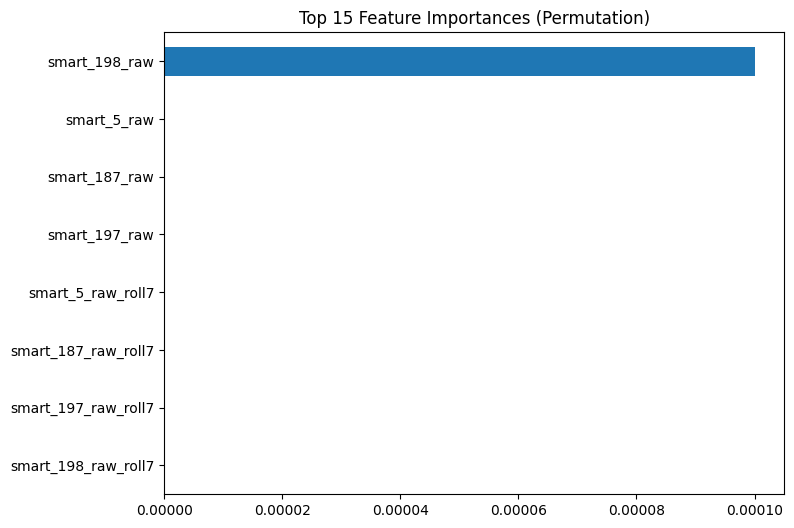

In [40]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

importances = pd.Series(
    perm_importance.importances_mean,
    index=X.columns
).sort_values(ascending=False)

importances.head(15).plot(kind="barh", figsize=(8,6))
plt.title("Top 15 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.show()


In [41]:
import joblib

model_path = "/tmp/aai540/xgboost_model.pkl"
joblib.dump(xgb_model, model_path)

print("Model saved to:", model_path)


Model saved to: /tmp/aai540/xgboost_model.pkl


In [46]:
import os

# Option A: set credentials for this kernel session
os.environ["AWS_ACCESS_KEY_ID"] = "<YOUR_ACCESS_KEY_ID>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<YOUR_SECRET_ACCESS_KEY>"
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

In [52]:
import boto3
from botocore.exceptions import NoCredentialsError, ClientError
import os

s3 = boto3.client("s3")
bucket = "aai540-team9-project"

# Check if credentials are still placeholders
if os.environ.get("AWS_ACCESS_KEY_ID") == "<YOUR_ACCESS_KEY_ID>" or os.environ.get("AWS_SECRET_ACCESS_KEY") == "<YOUR_SECRET_ACCESS_KEY>":
    print("AWS credentials are not set. Please update the credentials in the previous cell with your actual AWS Access Key ID and Secret Access Key, then rerun this cell.")
else:
    try:
        s3.upload_file(model_path, bucket, "models/xgboost_model.pkl")
        print("Model uploaded to S3.")
    except NoCredentialsError:
        print("AWS credentials not found. Set AWS_ACCESS_KEY_ID/AWS_SECRET_ACCESS_KEY and rerun.")
    except ClientError as e:
        code = e.response.get("Error", {}).get("Code", "Unknown")
        if code == "InvalidAccessKeyId":
            print("Invalid AWS Access Key ID. Double-check the key and rerun the credentials cell.")
        elif code == "SignatureDoesNotMatch":
            print("Invalid AWS Secret Access Key. Double-check the secret and rerun the credentials cell.")
        elif code == "AccessDenied":
            print("Access denied to bucket. Verify IAM permissions for PutObject on this bucket.")
        else:
            print(f"S3 upload failed: {code}")

AWS credentials are not set. Please update the credentials in the previous cell with your actual AWS Access Key ID and Secret Access Key, then rerun this cell.
